In [1]:
import torch
from sklearn.manifold import TSNE
from torchvision.models.feature_extraction import create_feature_extractor
import matplotlib.pyplot as plt
from matplotlib import patches
import torch.nn as nn
from models.baselines.mulsa.inference import MULSAInference
from models.baselines.mulsa.src.datasets.imi_datasets import ImitationEpisode
from models.baselines.mulsa.src.models.encoders import (
    make_vision_encoder,
    make_audio_encoder,
)
from models.baselines.mulsa.src.models.imi_models import Actor
from models.baselines.mulsa.src.engines.engine import ImiEngine
import numpy as np
import os
import yaml
from torch.utils.data import DataLoader

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
config_path = '/home/punygod_admin/SoundSense/soundsense/models/baselines/mulsa/conf/imi/train.yaml'
with open(config_path) as f:
        config = yaml.load(f, Loader=yaml.FullLoader)

In [4]:
model_path = "/home/punygod_admin/SoundSense/soundsense/models/baselines/mulsa/lightning_logs/mulsa_unimodal_simple_task_103-31-18:34:39/03-31-18:34:39.ckpt"

# v_encoder = make_vision_encoder(config['encoder_dim'])
# a_encoder = make_audio_encoder(config['encoder_dim'] * config['num_stack'], config['norm_audio'])

# model = Actor(v_encoder, a_encoder, config)
# model.load_state_dict(model_path)

model = MULSAInference.load_from_checkpoint(model_path).cuda()
# model.eval()

# feature_extractor_model = nn.Sequential(*list(model.children())[:-1])
# model = feature_extractor_model.to('cuda')

model.eval()

/home/punygod_admin/miniconda3/envs/muls/lib/python3.10/site-packages/pytorch_lightning/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.2.1, which is newer than your current Lightning version: v2.2.0.post0
/home/punygod_admin/miniconda3/envs/muls/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/punygod_admin/miniconda3/envs/muls/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/punygod_admin/miniconda3/envs/muls/lib/python3.10/site-packages/tor

MULSAInference(
  (actor): Actor(
    (v_encoder): Encoder(
      (feature_extractor): ResNet(
        (conv1): Conv2d(5, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Module(
          (0): Module(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu): ReLU(inplace=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (1): Module(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1

In [5]:

        
np.random.seed(0)
run_ids = os.listdir(config['dataset_root'])
np.random.permutation(run_ids)
split = int(config['train_val_split']*len(run_ids))
train_episodes = run_ids[:split]
val_episodes = run_ids[split:]

print("Train episodes: ", len(train_episodes))
print("Val episodes: ", len(val_episodes))

train_set = torch.utils.data.ConcatDataset(
    [
        ImitationEpisode(config, run_id)
        for run_id in train_episodes
    ]
)
val_set = torch.utils.data.ConcatDataset(
    [
        ImitationEpisode(config, run_id, train=False)
        for run_id in val_episodes
    ]
)

train_loader = DataLoader(train_set, config["batch_size"], num_workers=config["num_workers"])
val_loader = DataLoader(val_set, num_workers=config["num_workers"], shuffle=False,batch_size=1)

Train episodes:  80
Val episodes:  20


In [49]:
weights = []
targets_list = []
indices = []

for i, (img, target) in enumerate(val_loader):
    # print(i, (img[0].shape), (img[1][0].shape), target.shape)
    # img[0] = [element[-1, :].cuda() for element in img[0]]
    img[0] = img[0][-1]
    # img[1] = img[1].cuda()
    # target = target[:,-1,:]
    # print(i, (img[0][0].shape), (img[1][0].shape), target.shape)
    if i > 999:
        break
    with torch.no_grad():
        _, output, _  = model(img)
    weights.append(output.cpu().numpy())
    targets_list.append(target)
    indices.append(i)

In [54]:
## squeeze dimension 1
weights = np.squeeze(np.array(weights), axis=1)

In [4]:
# Example attention weights (randomly generated)
# num_heads = 2
# input_seq_len = 5
# output_seq_len = 4

# # Random attention weights for each head
# attention_example = np.random.rand(num_heads, output_seq_len, input_seq_len)
# print(attention_example[0])

[[0.65863797 0.67191951 0.09632743 0.73171509 0.86719185]
 [0.14223084 0.304478   0.7721001  0.04947649 0.09992013]
 [0.52789738 0.18109734 0.28301091 0.2693724  0.76023247]
 [0.91387682 0.83954926 0.65504483 0.0796263  0.393055  ]]


In [43]:
# attention_weights = np.load('attention_scores.npy')
attention_weights = weights[0]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

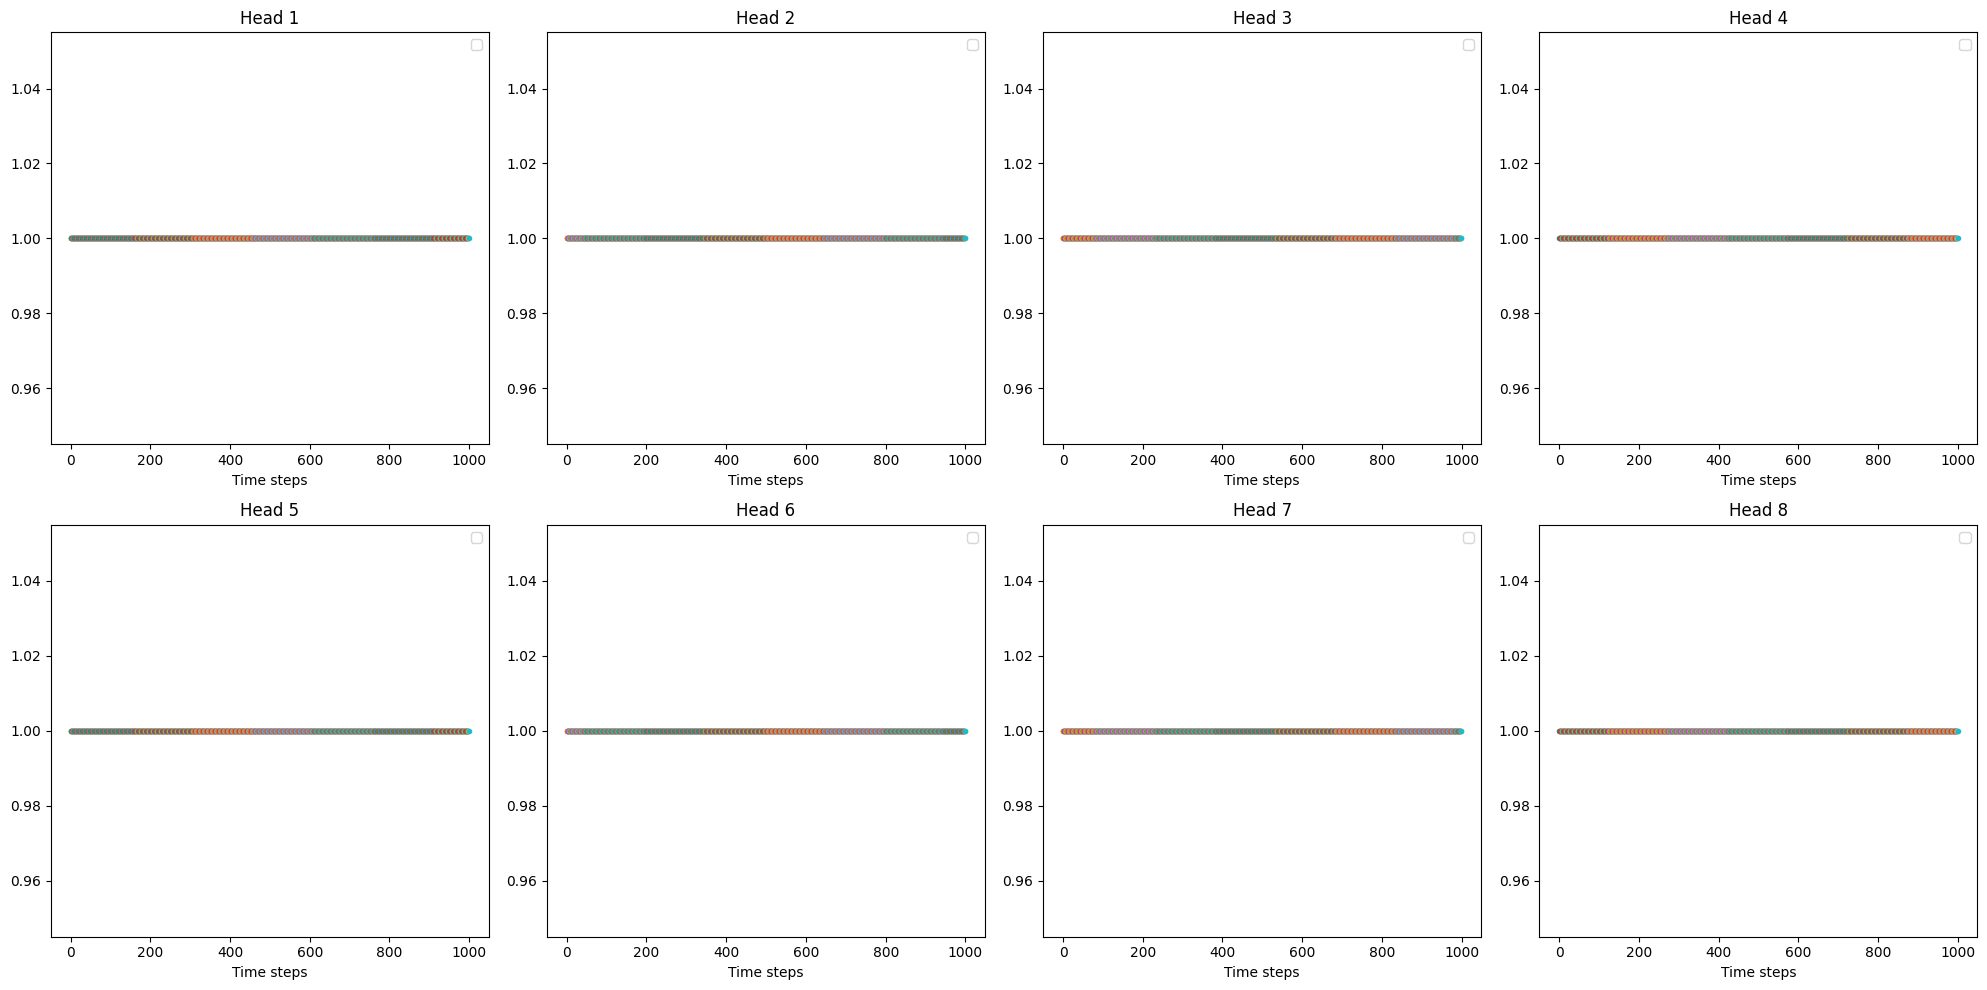

In [68]:

# fig, axs = plt.subplots(2, 4, figsize=(20, 10))

# for i in range(weights.shape[0]):
#     for j in range(weights.shape[1]):
#         axs[i][j].plot(weights[i, j].squeeze())  # Plot the time series
#         axs[i][j].set_title(f'Head {i+1}, Head Position {j+1}')

# plt.tight_layout()
# plt.show()
# plt.figure(figsize=(10, 6))
# for j in range(weights.shape[1]):
    
#     for i in range(weights.shape[0]):
#         if i == 0:
#             plt.plot(i,weights[i][j].squeeze(), '.', label='Head '+str(j))
#         else:
#             plt.plot(i,weights[i][j].squeeze(), '.')
#     plt.xlabel('Time steps')

#     plt.legend()
#     plt.show()
fig, axs = plt.subplots(2, 4, figsize=(20, 10))

for j in range(weights.shape[1]):
    row = j // 4
    col = j % 4
    
    for i in range(weights.shape[0]):
        axs[row, col].plot(i,weights[i][j].squeeze(), '.')
        axs[row, col].set_xlabel('Time steps')
        axs[row, col].set_title(f'Head {j+1}')
        axs[row, col].legend()

plt.tight_layout()
plt.show()

(8, 1, 1)


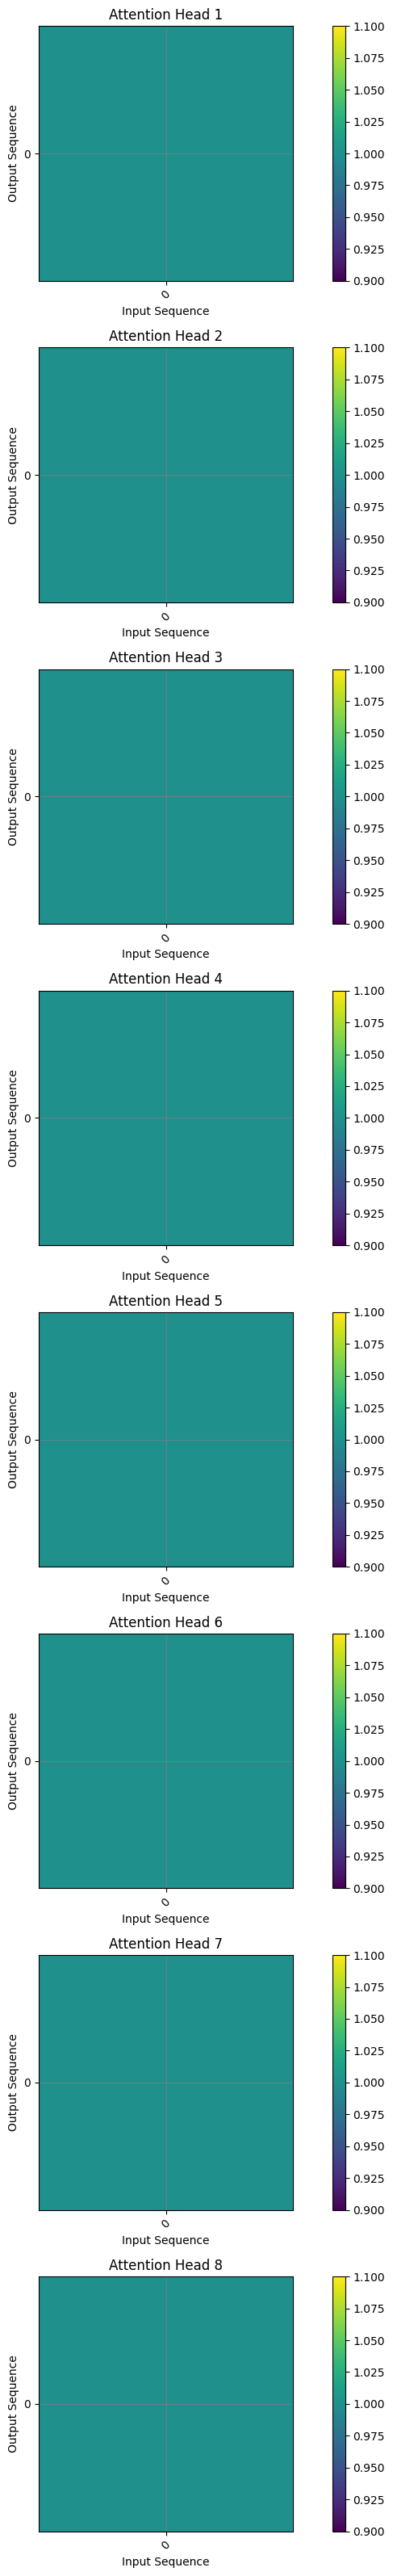

In [52]:
# Function to visualize attention weights
def visualize_attention(attention_weights):
    num_heads, output_seq_len, input_seq_len = attention_weights.shape
    print(attention_weights.shape)
    fig, axes = plt.subplots(nrows=num_heads, ncols=1, figsize=(10, 4*num_heads))
    # print(enumerate(axes))
    
    for i, ax in enumerate(axes):
        # print(i)
        ax.set_title(f'Attention Head {i+1}')
        ax.imshow(attention_weights[i], cmap='viridis', interpolation='nearest', aspect='auto')
        ax.set_xlabel('Input Sequence')
        ax.set_ylabel('Output Sequence')
        ax.set_xticks(np.arange(input_seq_len))
        ax.set_yticks(np.arange(output_seq_len))
        ax.grid(color='gray', linestyle='-', linewidth=0.5)
        ax.xaxis.set_tick_params(rotation=45)
        ax.colorbar = ax.figure.colorbar(ax.imshow(attention_weights[i]), ax=ax)
    
    plt.tight_layout()
    plt.show()


# Visualize attention weights
visualize_attention(attention_weights)
